Questo notebook consente l'analisi di un singolo fornitore.
Per analizzare le statistiche di un fornitore per l'anno 2017, caricare il file *data/anac/anac_indicepa_2017.tsv*. Per analizzare le statistiche di un fornitore su tutto il dataset, caricare il file *data/anac/anac_indicepa_all.tsv*


In [1]:
import pandas as pd
import numpy
import csv
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321761 entries, 0 to 1321760
Data columns (total 24 columns):
cfStrutturaProponente                1321761 non-null int64
cig                                  1321754 non-null object
denominazioneStrutturaProponente     1321602 non-null object
oggetto                              1321651 non-null object
sceltaContraente                     1321758 non-null object
importoAggiudicazione                1321760 non-null float64
importoSommeLiquidate                1321760 non-null float64
dataInizio                           1321761 non-null object
dataUltimazione                      1148870 non-null object
jsonPartecipanti                     1321761 non-null object
jsonAggiudicatari                    1321761 non-null object
totalePartecipanti                   1321761 non-null int64
totaleAggiudicatari                  1321761 non-null int64
totaleRaggruppamentopartecipanti     1321761 non-null int64
totaleRaggruppamentoAggiudicatari  

In [4]:
cfPrimoaggiudicatario = "02559020793"

In [5]:
df_aggiudicatario = df.loc[df["cfPrimoaggiudicatario"] == cfPrimoaggiudicatario]

### Bandi di gara Vinti

Campi analizzati:
1. totaleRaggruppamentopartecipanti: numero di raggruppamenti partecipanti ad un bando di gara; 
2. totalePartecipanti: numero di partecipanti (non raggruppamento) ad un bando di gara; 
3. YearMonth: Anno e mese in cui è stata aggiudicata la gara; 
4. denominazioneStrutturaProponente: denominazione struttura proponente;
5. tipologia_istat: tipologia istat della struttura proponente;
6. regione: regione di appartenenza della struttura proponente;
7. provincia: provincia di appartenenza della struttura proponente;
8. comune: comune di appartenenza della struttura proponente;

Cose da fare:

1. Aggiungere i competitor del fornitore in analisi
2. Analizzare i campi jsonPartecipanti e jsonAggiudicatari in modo da ottenere statistiche anche sui bandi in cui un fornitore ha partecipato ma non vinto;
3. Associare ai campi in analisi anche statistiche circa l'importo di aggiudicazione (media, somma, max, min);
4. Per data record su raggruppamenti applicare algoritmi di frequent itemset mining in modo da scoprire se ci sono pattern ricorrenti nei raggruppamenti;

In [6]:
df_aggiudicatario['dataInizio'] = pd.to_datetime(df['dataInizio'], errors='coerce')
df_aggiudicatario['YearMonth'] = df_aggiudicatario['dataInizio'].map(lambda x: 100*x.year + x.month)
#df_aggiudicatario[['YearMonth', "dataInizio"]].head()

/Users/fabiana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/fabiana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
df_aggiudicatario_count = df_aggiudicatario.groupby(["cfStrutturaProponente"])["cfStrutturaProponente"].agg(["count"]).reset_index(0)#.sort_values(['count'], ascending=False)
df_aggiudicatario_sum = df_aggiudicatario[["importoSommeLiquidate","importoAggiudicazione", "cfStrutturaProponente"]].groupby(["cfStrutturaProponente"]).sum().reset_index()

df_join = df_aggiudicatario_count.set_index('cfStrutturaProponente').join(df_aggiudicatario_sum.set_index('cfStrutturaProponente'))

columns_to_add = ["totaleRaggruppamentopartecipanti","totalePartecipanti","YearMonth","dataInizio","cfStrutturaProponente","denominazioneStrutturaProponente", "tipologia_istat", "regione", "provincia", "comune"]
df_denominazione_aggiudicatario = df_aggiudicatario[columns_to_add]
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario.set_index("cfStrutturaProponente")
df_denominazione_aggiudicatario = df_denominazione_aggiudicatario[~df_denominazione_aggiudicatario.index.duplicated(keep='first')]

final_df = pd.merge(df_join,df_denominazione_aggiudicatario, left_index=True, right_index=True, how='left')

#final_df =final_df.reset_index().set_index('denominazioneStrutturaProponente')
final_df =final_df.reset_index()

In [8]:
final_df.head()

,cfStrutturaProponente,count,importoSommeLiquidate,importoAggiudicazione,totaleRaggruppamentopartecipanti,totalePartecipanti,YearMonth,dataInizio,denominazioneStrutturaProponente,tipologia_istat,regione,provincia,comune
0,8010803,2,77767.43,306425.51,0,1,201707,2017-07-01,COMUNE DI CINQUEFRONDI SERVIZI TECNICI,Comuni e loro Consorzi e Associazioni,Calabria,RC,Cinquefrondi
1,137710802,1,0.00,9142.00,0,4,201711,2017-11-23,COMUNE DI GIOIA TAURO,Comuni e loro Consorzi e Associazioni,Calabria,RC,Gioia Tauro
2,278200795,4,342999.77,348362.73,0,1,201702,2017-02-16,COMUNE DI SERRA SAN BRUNO,Comuni e loro Consorzi e Associazioni,Calabria,VV,Serra San Bruno
3,282020791,1,6166.35,10401.40,0,1,201705,2017-05-25,COMUNE DI ZAGARISE,Comuni e loro Consorzi e Associazioni,Calabria,CZ,Zagarise
4,304310790,5,179122.87,506071.89,0,1,201712,2017-12-31,COMUNE DI CROPANI,Comuni e loro Consorzi e Associazioni,Calabria,CZ,Cropani


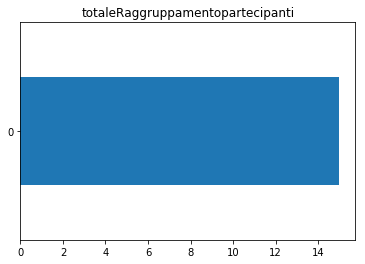

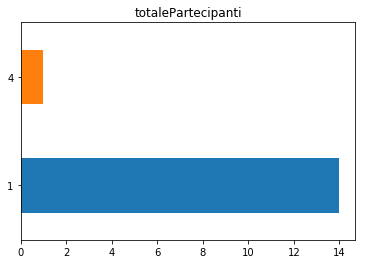

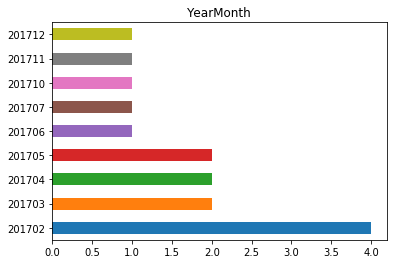

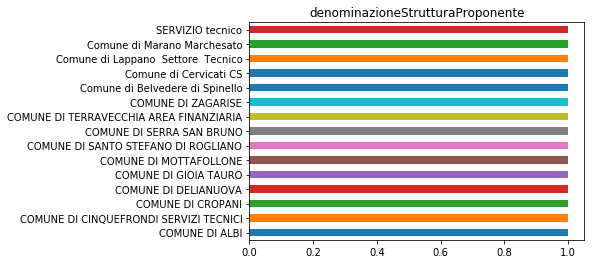

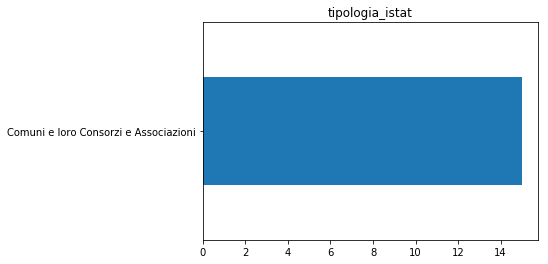

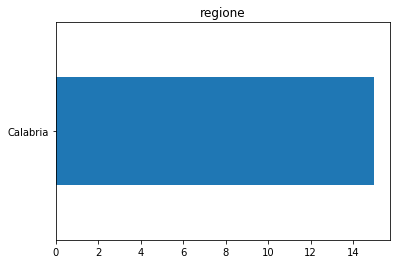

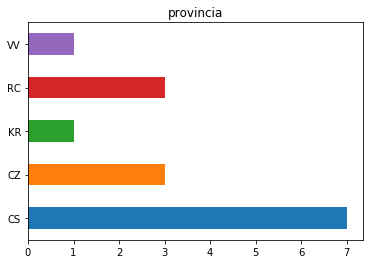

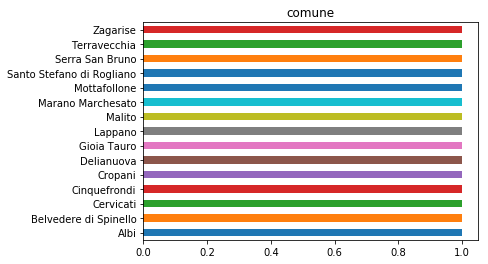

In [9]:
columns_to_visualize = ["totaleRaggruppamentopartecipanti","totalePartecipanti","YearMonth","denominazioneStrutturaProponente", "tipologia_istat", "regione", "provincia", "comune"]

for col in columns_to_visualize:
    #print(col)

    final_df[col].value_counts().sort_index().plot(kind='barh', title= col)
    plt.show()
    
 